In [348]:
# Calling libraries:
from __future__ import division
%matplotlib inline
import numpy as np
from time import time
from scipy.stats import *
from pylab import plot, show, legend
import matplotlib.pyplot as plt
import math 
import pandas

In [218]:
def propagate_Lorenz63(X, dt, delta, theta) :
    """
    usual: 3D Lorenz model + multiplicative noise
    compute one step forward, usual Euler-Maruyama discretization
    """
    sigma, rho, beta, noise_intensity = theta[:]
    #ODE forward + noise
    N = np.shape(X)[0]
    sqdt = np.sqrt(dt)

    W = np.random.randn(int(delta/dt),N)
    for i in range( int(delta/dt) ) :
        xx = np.zeros(( N, 3 ))
        xx[:,0] = X[:,0] + dt*sigma*(X[:,1] - X[:,0]) + noise_intensity*X[:,0]*sqdt*W[i,:]
        xx[:,1] = X[:,1] + dt*(X[:,0]*(rho - X[:,2]) - X[:,1]) + noise_intensity*X[:,1]*sqdt*W[i,:]
        xx[:,2] = X[:,2] + dt*(X[:,0]*X[:,1] - beta*X[:,2]) + noise_intensity*X[:,2]*sqdt*W[i,:]
        X [:,:] = xx[:,:]
    
    return X

In [250]:
def simulate_observations(x_0, T, dt, delta, H, R, theta) : 
    """
    generate a sequence of observations x_0 : initialization
    T = number of observations
    delta = time between observations
    """
    m  = np.shape(H)[0]
    y  = np.zeros(( m, T ))
    X  = np.zeros(( 1, m ))
    trajectory = np.zeros(( 3, T ))
    X[:,:] = x_0
    
    for t in range(T) :
        X = propagate_Lorenz63(X, dt, delta, theta)
        trajectory[:,t] = X[0,:]
        y[:,t] = np.dot(H, X[0,:]) + np.random.multivariate_normal(np.zeros(m), R, 1)
                        
    return trajectory, y

In [251]:
dt    = 10**-3
delta = 10*dt
T     = 10**3
n     = 3

sigma, rho, beta, noise_intensity = 10, 28, 8/3, 0.5
theta = [ sigma, rho, beta, noise_intensity ]

#setup measurement process

observation_points = np.arange(0, n)
m = len(observation_points)
H = np.zeros(( m, n ))
for i in range(m):
    H[ i, observation_points[i] ] = 1

sigma_error = 0.5    
R = sigma_error*np.diag(np.ones(m))

x_0 = [-5.91652, -5.52332, 24.5723]

C:\Python34\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


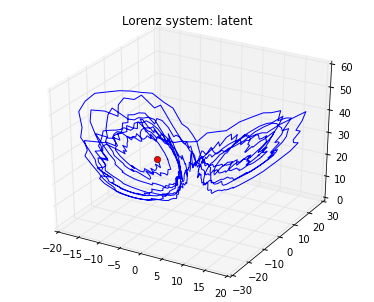

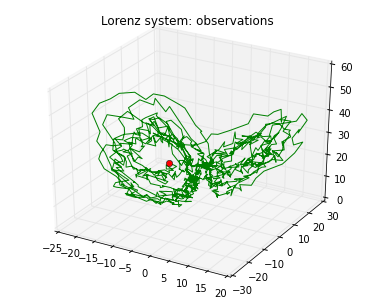

In [252]:
hidden, observed = simulate_observations(x_0, T, dt, delta, H, R, theta)
plt.rcParams['figure.figsize'] = (5.0, 4.0)

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
ax.plot(trajectory[0,:], trajectory[1,:], trajectory[2,:])
ax.plot(trajectory[0,0:1], trajectory[1,0:1], trajectory[2,0:1], 'ro')
plt.title("Lorenz system: latent")

fig = plt.figure()
ax = Axes3D(fig)
ax.plot(y[0,:], y[1,:], y[2,:], color='green')
ax.plot(y[0,0:1], y[1,0:1], y[2,0:1], 'ro')
plt.title("Lorenz system: observations")

#### Potential function

In [205]:
def g(y, X, H, R) :
    
    E = y - np.transpose(np.dot(H,np.transpose(X)))          # denotes error
    R_inv = np.linalg.inv(R)
    
    return np.exp(-0.5*np.diag(np.dot(E, np.dot( R_inv, np.transpose(E) ))))

#### Bootstrap particle filter:

In [258]:
def bootstrap_PF(x_0, N, theta, y, dt, delta, g, H, R) :
    
    T  = np.shape(y)[1]
    particles = np.zeros(( T+1, N, 3 )) 
    weights   = np.ones(N)/N
    W = np.zeros((T, N))
    log_NC = 0
    particles[0] = x_0
        
    # Run the coupled particle filter:
    for t in range(T):
        
        particles[t+1] = propagate_Lorenz63(particles[t], dt, delta, theta)
        weights = weights*g(y[:,t], particles[t+1], H, R)
        log_NC  += np.log(np.sum(weights))
        weights  /= np.sum(weights)
        W[t,:] = weights[:]
        
        # Resample
        particles[t+1,:] = particles[t+1,np.random.choice(N,N,True,weights)]
        weights = np.ones(N)/N
    
    return particles, weights, log_NC

#### Pseudo-marginal MCMC

In [234]:
def prior(theta, prior_mean, prior_sd) :
    return (np.prod(np.exp(-1/(2*prior_sd**2)*( (theta-prior_mean))**2 )))

In [261]:
def pseudo_marginal_MCMC(x_0, y, theta_0, n_particles, n_mcmc, scale, prior_mean, prior_sd) :
    
    theta_dim = len(theta_0)
    theta_chain = np.zeros((n_mcmc+1, theta_dim)); theta_chain[0] = theta_0[:]
    lls = np.zeros(n_mcmc+1) 
    lls[0] = bootstrap_PF(x_0, n_particles, theta_chain[0], y, dt, delta, g, H, R)[-1]
    
    for n in range(n_mcmc) :
        theta_proposed = theta_chain[n] + scale*np.random.randn(theta_dim) 
        ll_proposed = bootstrap_PF(x_0, n_particles, theta_proposed, y, dt, delta, g, H, R)[-1]
        acceptance_ratio = (np.exp(ll_proposed-lls[n]) *
                            prior(theta_proposed, prior_mean, prior_var)/prior(theta_chain[n], prior_mean, prior_sd))
        if uniform.rvs(0,1,1) < acceptance_ratio :
            lls[n+1], theta_chain[n+1] = ll_proposed, theta_proposed[:]
        else :
            lls[n+1], theta_chain[n+1] = lls[n], theta_chain[n]
    return theta_chain

### Does it track?


* Starting at wrong positions

In [262]:
n_particles = 10**3
initial = 10*np.random.randn(N,3) 

t_start, t_end = 200, 400

particles, W, log_NC = bootstrap_PF(initial, n_particles, theta, observed[:,t_start:t_end], dt, delta, g, H, R)

C:\Python34\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


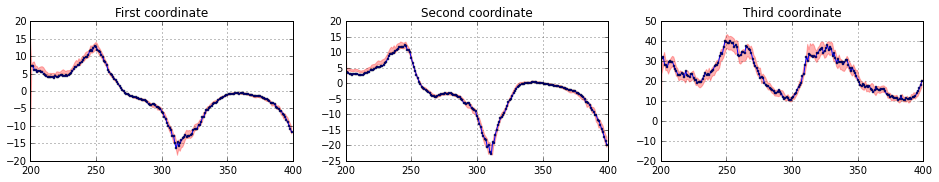

In [263]:
plt.rcParams['figure.figsize'] = (16,2.5)
fig = plt.figure()
plt.subplot(1,3,1)
plt.plot(np.arange(t_start,t_end), hidden[0,t_start:t_end], 'bo-', markersize=2)
plt.fill_between(np.arange(t_start,t_end), np.percentile(particles[0:t_end-t_start,:,0],axis=1,q=5), 
                 np.percentile(particles[0:t_end-t_start,:,0],axis=1,q=95), color='red', alpha=.3)
plt.grid(True)
plt.title('First coordinate')
plt.subplot(1,3,2)
plt.plot(np.arange(t_start,t_end), hidden[1,t_start:t_end], 'bo-', markersize=2)
plt.fill_between(np.arange(t_start,t_end), np.percentile(particles[0:t_end-t_start,:,1],axis=1,q=5), 
                 np.percentile(particles[0:t_end-t_start,:,1],axis=1,q=95), color='red', alpha=.3)
plt.grid(True)
plt.title('Second coordinate')
plt.subplot(1,3,3)
plt.plot(np.arange(t_start,t_end), hidden[2,t_start:t_end], 'bo-', markersize=2)
plt.fill_between(np.arange(t_start,t_end), np.percentile(particles[0:t_end-t_start,:,2],axis=1,q=5), 
                 np.percentile(particles[0:t_end-t_start,:,2],axis=1,q=95), color='red', alpha=.3)
plt.grid(True)
plt.title('Third coordinate')

### See is this approximate initial points scheme works for a short segment. 

* True starting position is known because we know true trajectory.

In [360]:
n_particles = 1000
n_mcmc = 10**4
scale = [1, 0.5, 0, 0]
prior_mean = np.copy(theta)
prior_sd = 10*np.ones(4)

t_start, t_end = 100, 200

#### True MCMC

In [361]:
start = time()
theta_chain_true = pseudo_marginal_MCMC(hidden[:,t_start-1], observed[:,t_start:t_end], theta, 
                                        n_particles, n_mcmc, scale, prior_mean, prior_sd)
print( round((time() - start)/60, 2), 'minutes' )

120.78 minutes


#### Approx MCMC:

In [362]:
start = time()

N = 10**3

result = bootstrap_PF(10*np.random.randn(N,3), N, theta, observed[:,t_start-100:t_start], dt, delta, g, H, R)
XX, w = result[0], result[1]/np.sum(result[1])
initial = XX[-1, np.random.choice(a=N,size=n_particles,p=w)]
theta_chain_aprx = pseudo_marginal_MCMC(initial, observed[:,t_start:t_end], theta, 
                                        n_particles, n_mcmc, scale, prior_mean, prior_sd)
print( round((time() - start)/60, 2), 'minutes' )

120.87 minutes


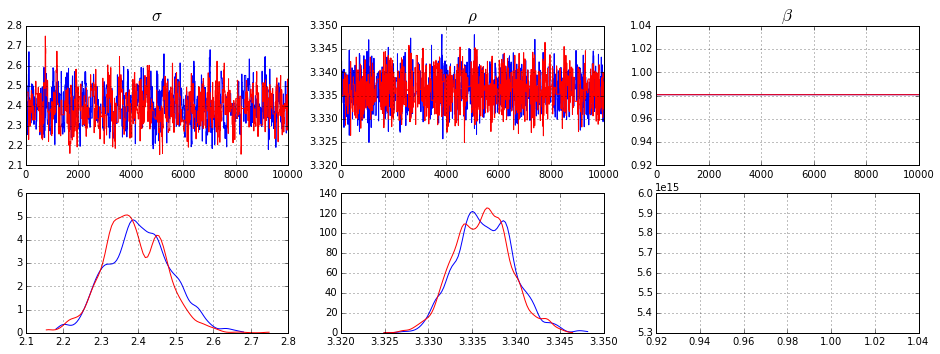

In [363]:
plt.rcParams['figure.figsize'] = (16,5.5)
fig = plt.figure()

names = [r'$\sigma$', r'$\rho$', r'$\beta$']

for i in range(3) :
    plt.subplot(2,3,i+1)
    plt.plot(np.log(theta_chain_true[:,i]), color='b')
    plt.plot(np.log(theta_chain_aprx[:,i]), color='r')
    plt.grid(True)
    plt.title(names[i], fontsize=17)

for i in range(3) :

    plt.subplot(2,3,4+i) 
    x_vals = np.linspace(start=np.min(np.log(theta_chain_true[:,i])), 
                         stop=np.max(np.log(theta_chain_true[:,i])), num=100)
    plt.plot(x_vals, gaussian_kde(np.log(theta_chain_true[:,i])) (x_vals), color='b') 
    x_vals = np.linspace(start=np.min(np.log(theta_chain_aprx[:,i])), 
                         stop=np.max(np.log(theta_chain_aprx[:,i])), num=100)
    plt.plot(x_vals, gaussian_kde(np.log(theta_chain_aprx[:,i])) (x_vals), color='r')
    plt.grid(True)

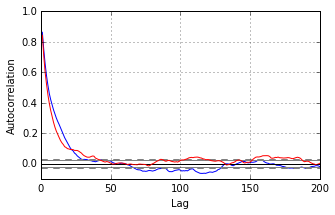

In [378]:
plt.rcParams['figure.figsize'] = (5,3)
ax = pandas.plotting.autocorrelation_plot(np.log(theta_chain_true[1000:,1]), color='b')
ax = pandas.plotting.autocorrelation_plot(np.log(theta_chain_aprx[1000:,1]), color='r')
ax.set_xlim(0,200)
ax.set_ylim(-0.1,1)
ax.grid(True)